In [2]:
# %env PYTORCH_ENABLE_MPS_FALLBACK=1

from bins import Bins
from utils import calcAllChi2, calcOneChi2, HistMaker_1d, diffHist
from ROOT import TFile, TH1, TH3F, TF2, TCanvas, TStyle, gStyle, Form, Fit
import scipy.optimize as opt
import math
import calendar, os
from time import time, gmtime


In [3]:
read_saved = False
range_used = range(0,12)

if read_saved:
    DIR_NAME = "results_mixing_nu15_noise1em4_1d"
else:
    current_GMT =   gmtime()
    time_stamp = calendar.timegm(current_GMT)
    DIR_NAME = f'results_{time_stamp}'
    os.mkdir(DIR_NAME)

In [4]:
bins = Bins.readFrom("ranges.yml")
histMakerData = HistMaker_1d("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins)
#histMakerData = HistMaker("088_090_ag123ag_2500A_accepted_np.dat", "_data", bins)
histsData = histMakerData.makeHists()
histMakerMC_rho = HistMaker_1d("mar19_diele_inmedium_heli0cm_np.dat", "_MC", bins)
histMakerMC_pi0 = HistMaker_1d("mar19_diele_pi0_heli0cm_np.dat", "_MC", bins)
def getHistMakerMC(HIST_INDEX):
   # return histMakerMC_pi0 if HIST_INDEX < 3 else histMakerMC_rho
    return histMakerMC_rho


iter 0
Before processing events 13:31:44
After processing events 13:31:45
iter 1
Before processing events 13:32:00
After processing events 13:32:01
iter 2
Before processing events 13:32:07
After processing events 13:32:08


Warning in <TROOT::Append>: Replacing existing TH1: hmass_MC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hz_MC (Potential memory leak).


Info in <TCanvas::Print>: gif file results_1697542284/base_hists_pi0_MC.gif has been created


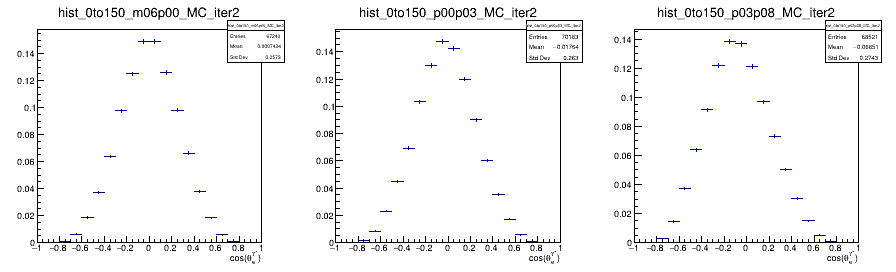

In [5]:
base_hists_pi0 = histMakerMC_pi0.builder.base_hists
can3 = TCanvas("can3","can3",900,300)
can3.Divide(3,1)
can3.Draw()
for i, hist in enumerate(base_hists_pi0[0]):
    if i < 3:
        can3.cd(i+1)
        if not isinstance(hist, list):
            hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
            hist.Draw()
        else:
            print(hist)
can3.SaveAs(f"{DIR_NAME}/base_hists_pi0_MC.gif")

Info in <TCanvas::Print>: gif file results_1697542284/base_hists_rho_MC.gif has been created


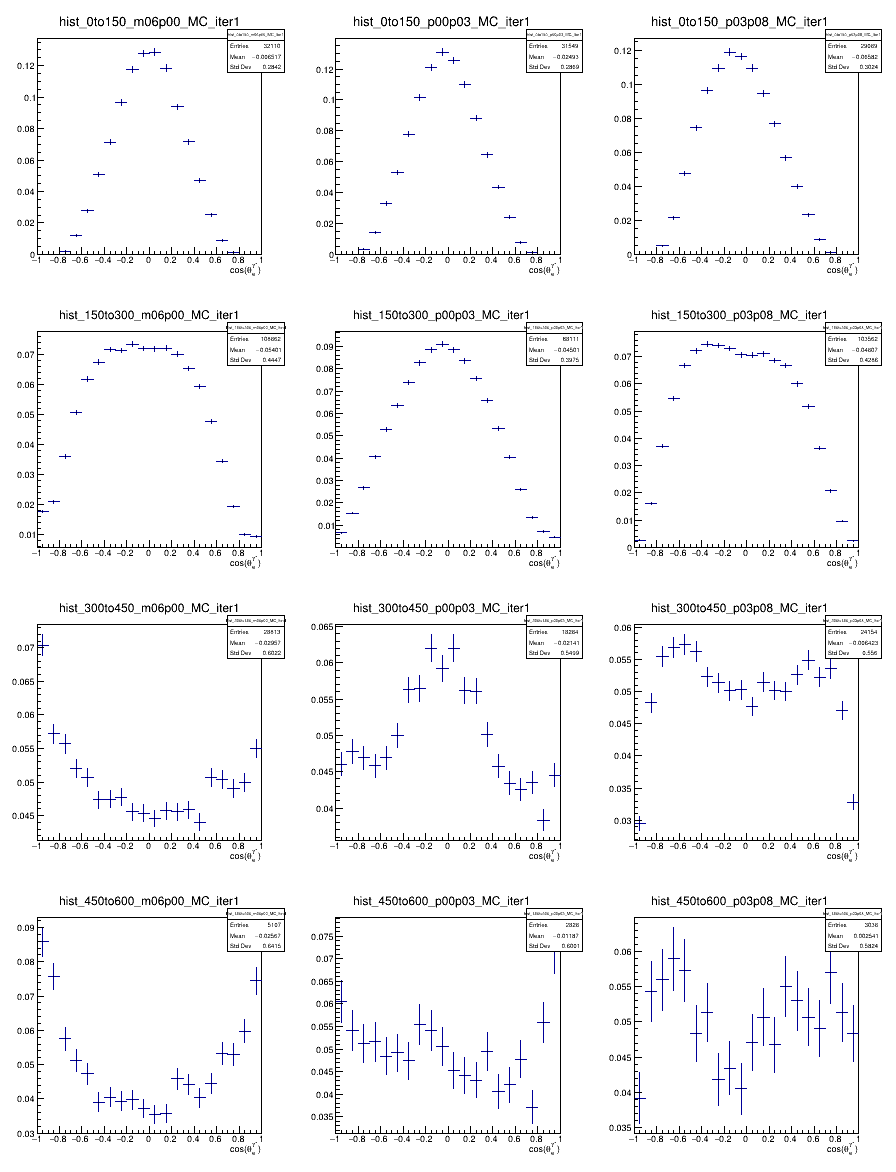

In [6]:
base_hists_rho = histMakerMC_rho.builder.base_hists
can5 = TCanvas("can5","can5",900,1200)
can5.Divide(3,4)
can5.Draw()
for i, hist in enumerate(base_hists_rho[0]):
    can5.cd(i+1)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        hist.Draw()
    else:
        print(hist)
can5.SaveAs(f'{DIR_NAME}/base_hists_rho_MC.gif')


Info in <TCanvas::Print>: gif file results_1697542284/histsData.gif has been created


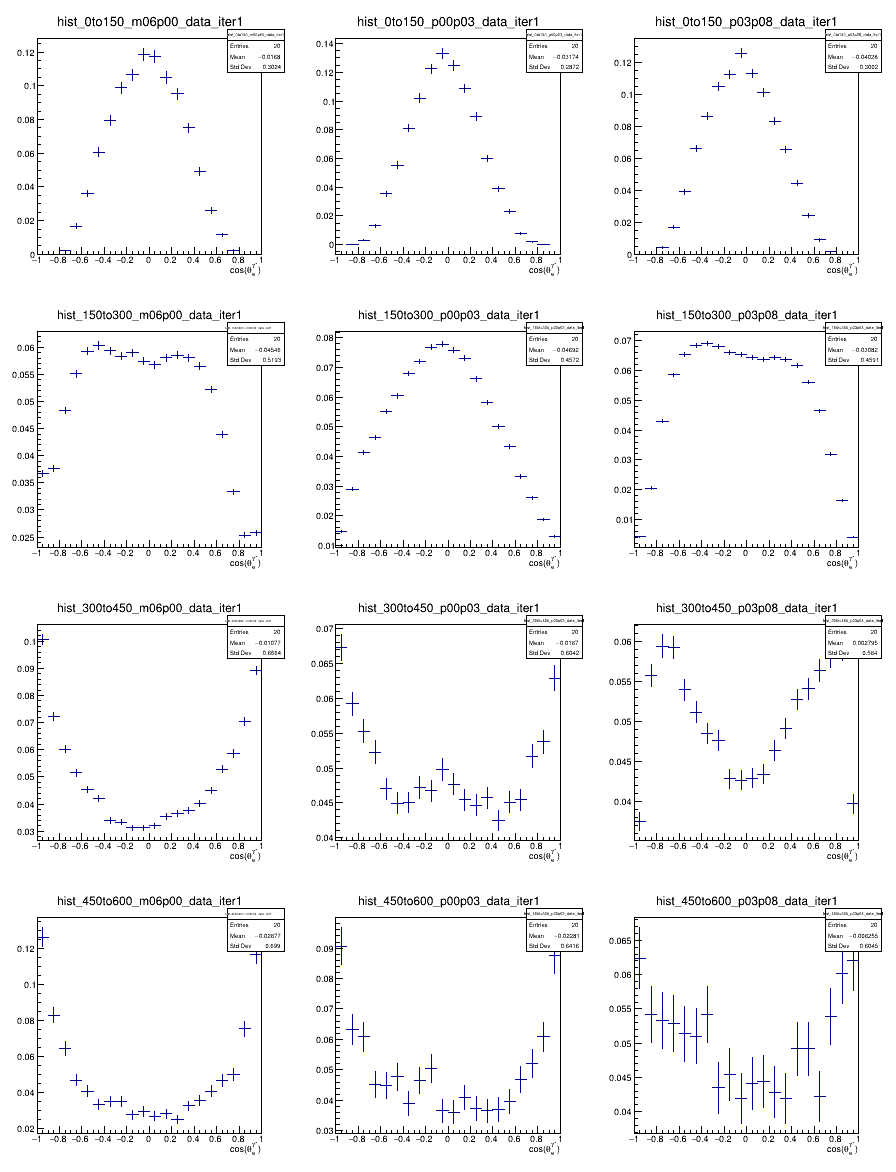

In [7]:
can4 = TCanvas("can4","can4",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData[0]):
    can4.cd(i+1)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        hist.Draw("COLZ")
    else:
        print(hist)

can4.SaveAs(f'{DIR_NAME}/histsData.gif')

In [8]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [9]:
TH1.SetDefaultSumw2

gpytorch.settings.fast_pred_var()
gpytorch.settings.fast_pred_samples()

N_PARAMS = 1

In [10]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-1, ],
                       [ 1, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [11]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
# class GPModel(gpytorch.models.ApproximateGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        mean_x = mean_x.to(mps_device)
        covar_x = covar_x.to(mps_device)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    train_x = train_x.to(mps_device)
    train_y = train_y.to(mps_device)

    # declare the GP
    noise = 1e-4

   # likelihood = gpytorch.likelihoods.StudentTLikelihood()
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    likelihood = likelihood.to(mps_device)
    model = model.to(mps_device)

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model.cpu(), likelihood.cpu()

In [12]:
# TODO: Come back to standard version
#num_queries = 75
num_queries = 200
num_repeats = 1
num_samples = 150

In [13]:
# -2 is the default value when no feasible has been found
default_value = -1

def fit_bo(HIST_INDEX = 0):
    global bounds

    def objective(xx):
        def generator(xx):
            for x in xx:
                lambda_theta = x

                histsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
                chi2, ndf = calcOneChi2(histsMC[0][HIST_INDEX], histsData[0][HIST_INDEX])
                allHistsMC.append(histsMC[0][HIST_INDEX])
                if not chi2 or not ndf:
                    return torch.tensor([0])
                yield torch.tensor([1.0/(chi2 / ndf)])
        return torch.stack([a for a in generator(xx)])

    def one_starting_sample():
        result = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(N_PARAMS)
        return result

    feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

    best_fs = []

    print(f"HIST INDEX: {HIST_INDEX}")
    for trial in range(num_repeats):
       # print("trial", trial)

        torch.manual_seed(trial)
       # train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
       # while -2.0*train_x[0][0] - 1.0*train_x[0][2] < -2:
       #     train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
        train_x = torch.stack([one_starting_sample() for _ in range(num_samples)])
        train_utility = objective(train_x).to(mps_device)
        train_x = train_x.to(mps_device)

        for i in tqdm(range(num_queries)):
            feasible_incumbents[trial, i] = train_utility.max()
            before_fit_gp = time()
            utility_model, utility_likelihood = fit_gp_model(
                train_x, train_utility.squeeze(-1)
            )
            after_fit_gp = time()
            print("Fitting GP took " + str(after_fit_gp - before_fit_gp) + " seconds")
            best_f = train_utility.max()
            best_fs.append(best_f.item())
                
           # policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
           # policy = botorch.acquisition.analytic.LogExpectedImprovement(
            policy = botorch.acquisition.logei.qLogExpectedImprovement(
          # policy = botorch.acquisition.analytic.LogProbabilityOfImprovement(
          # policy = botorch.acquisition.analytic.PosteriorMean(
                model=utility_model,
                best_f=train_utility.max(),
            ).to(mps_device)

            before_optimize_acqf = time()
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                next_x, acq_val = botorch.optim.optimize_acqf(
                    policy,
                    bounds=bounds,
                    #q=5,
                    #num_restarts=5,
                    #raw_samples=400,
                    q=1,
                    num_restarts=40,
                    raw_samples=100,
                )
            after_optimize_acqf = time()
            print("Optimizing ACQF took " + str(after_optimize_acqf - before_optimize_acqf) + " seconds")

            next_utility = objective(next_x).to(mps_device)

            train_x = torch.cat([train_x, next_x])
            train_utility = torch.cat([train_utility, next_utility])
    torch.save(feasible_incumbents, f"{DIR_NAME}/incumbents_" + str(HIST_INDEX) + ".pth")
    fout = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root","RECREATE")
    fout.cd()
    for hist in allHistsMC:
       # print ("Writing hist: ", hist.GetName())
        hist.Write()
    for j, hists in enumerate(histsData):
        for k, hist in enumerate(hists):
                hist.Write()
               # print ("Writing hist: ", j, k, hist)
    fout.Close()

    with torch.no_grad():
        predictive_distribution = utility_likelihood(utility_model(xs))
        acquisition_score = policy(xs.unsqueeze(1))

    lambda_thetas     = train_x.flatten()
    
    c = torch.stack((
        torch.arange(0,num_queries, dtype=int),
        lambda_thetas[0:num_queries],
        train_utility.squeeze()[0:num_queries],
        (feasible_incumbents==feasible_incumbents.max())[0],
        feasible_incumbents[0]
    ),0).transpose(-2,-1)
    torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
    sort_index = c[:, N_PARAMS + 1].sort()[1]
    c_sorted = c[sort_index]
    train_x_sorted = train_x[sort_index]

    return c_sorted, train_x_sorted, predictive_distribution

In [14]:
c_sorted_all = []
train_x_sorted_all = []
predictive_mean_all = []
predictive_lower_all = []
predictive_upper_all = []

for HIST_INDEX in range_used:
    allHistsMC = []
    if read_saved:
        c_sorted = torch.load(f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        train_x_sorted = torch.load(f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        predictive_distribution = torch.load(f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

        file = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root", "read")
        names = [key.GetName() for key in file.GetListOfKeys()]
        names = [name for name in names if "MC" in name]
        for name in names:
            allHistsMC.append(file.Get(name))
    else:
        c_sorted, train_x_sorted, predictive_distribution = fit_bo(HIST_INDEX)
        print(c_sorted[-5:])
        
        torch.save(c_sorted, f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(train_x_sorted, f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(predictive_distribution, f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()
    print("AFTER_READING: ", predictive_mean[100], predictive_lower[100], predictive_upper[100])

    c_sorted_all.append(c_sorted)
    train_x_sorted_all.append(train_x_sorted)
    predictive_mean_all.append(predictive_mean)
    predictive_lower_all.append(predictive_lower)
    predictive_upper_all.append(predictive_upper)



HIST INDEX: 0


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 4.579393148422241 seconds
Optimizing ACQF took 0.10227108001708984 seconds
Fitting GP took 4.963261842727661 seconds
Optimizing ACQF took 0.10858297348022461 seconds
Fitting GP took 2.3718719482421875 seconds
Optimizing ACQF took 0.04617786407470703 seconds
Fitting GP took 3.3233859539031982 seconds
Optimizing ACQF took 0.10129117965698242 seconds
Fitting GP took 2.48144793510437 seconds
Optimizing ACQF took 0.0660710334777832 seconds
Fitting GP took 3.1628170013427734 seconds
Optimizing ACQF took 0.07892203330993652 seconds
Fitting GP took 3.3960459232330322 seconds
Optimizing ACQF took 0.022940874099731445 seconds
Fitting GP took 2.2161009311676025 seconds
Optimizing ACQF took 0.03595781326293945 seconds
Fitting GP took 4.045588970184326 seconds
Optimizing ACQF took 0.03777599334716797 seconds
Fitting GP took 4.057376861572266 seconds
Optimizing ACQF took 0.09781908988952637 seconds
Fitting GP took 3.872117042541504 seconds
Optimizing ACQF took 0.06298589706420898 sec

/Users/harabasz/helicity/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 2.225252151489258 seconds
Optimizing ACQF took 3.7663729190826416 seconds
Fitting GP took 4.8888099193573 seconds
Optimizing ACQF took 2.4038610458374023 seconds
Fitting GP took 2.2765848636627197 seconds
Optimizing ACQF took 1.7674758434295654 seconds
Fitting GP took 3.313995122909546 seconds
Optimizing ACQF took 1.2745490074157715 seconds
Fitting GP took 4.08525276184082 seconds
Optimizing ACQF took 2.11296010017395 seconds
Fitting GP took 2.5374200344085693 seconds
Optimizing ACQF took 2.1715610027313232 seconds
Fitting GP took 3.763477087020874 seconds
Optimizing ACQF took 1.7511711120605469 seconds
Fitting GP took 3.0786309242248535 seconds
Optimizing ACQF took 0.2725038528442383 seconds
Fitting GP took 2.386180877685547 seconds
Optimizing ACQF took 1.461771011352539 seconds
Fitting GP took 4.990486145019531 seconds
Optimizing ACQF took 2.210616111755371 seconds
Fitting GP took 3.8157951831817627 seconds
Optimizing ACQF took 1.866243839263916 seconds
Fitting GP too

  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 4.839116096496582 seconds
Optimizing ACQF took 1.861053228378296 seconds
Fitting GP took 2.2314839363098145 seconds
Optimizing ACQF took 0.3895149230957031 seconds
Fitting GP took 2.101180076599121 seconds
Optimizing ACQF took 1.1216917037963867 seconds
Fitting GP took 3.1278228759765625 seconds
Optimizing ACQF took 1.702652931213379 seconds
Fitting GP took 3.2677600383758545 seconds
Optimizing ACQF took 1.3324317932128906 seconds
Fitting GP took 1.9077260494232178 seconds
Optimizing ACQF took 0.5020287036895752 seconds
Fitting GP took 2.841080904006958 seconds
Optimizing ACQF took 1.5491039752960205 seconds
Fitting GP took 5.108396053314209 seconds
Optimizing ACQF took 1.094954013824463 seconds
Fitting GP took 3.945361852645874 seconds
Optimizing ACQF took 0.7726457118988037 seconds
Fitting GP took 3.476801872253418 seconds
Optimizing ACQF took 0.5739829540252686 seconds
Fitting GP took 3.763651132583618 seconds
Optimizing ACQF took 0.9739038944244385 seconds
Fitting G

/Users/harabasz/helicity/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 2.0614941120147705 seconds
Optimizing ACQF took 0.018017053604125977 seconds
Fitting GP took 2.4629340171813965 seconds
Optimizing ACQF took 0.1049661636352539 seconds
Fitting GP took 3.819485902786255 seconds
Optimizing ACQF took 0.038121938705444336 seconds
Fitting GP took 3.2069921493530273 seconds
Optimizing ACQF took 0.06608700752258301 seconds
Fitting GP took 2.7892467975616455 seconds
Optimizing ACQF took 0.016125917434692383 seconds
Fitting GP took 1.6467981338500977 seconds
Optimizing ACQF took 0.015034914016723633 seconds
Fitting GP took 1.9799389839172363 seconds
Optimizing ACQF took 0.06897306442260742 seconds
Fitting GP took 1.959216833114624 seconds
Optimizing ACQF took 0.016742944717407227 seconds
Fitting GP took 3.4585959911346436 seconds
Optimizing ACQF took 0.03278803825378418 seconds
Fitting GP took 3.156569004058838 seconds
Optimizing ACQF took 0.03961992263793945 seconds
Fitting GP took 2.6493959426879883 seconds
Optimizing ACQF took 0.0285508632659

/Users/harabasz/helicity/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 4.2977941036224365 seconds
Optimizing ACQF took 0.2717008590698242 seconds
Fitting GP took 2.923449754714966 seconds
Optimizing ACQF took 0.07327580451965332 seconds
Fitting GP took 2.1349620819091797 seconds
Optimizing ACQF took 0.06007504463195801 seconds
Fitting GP took 2.496857166290283 seconds
Optimizing ACQF took 0.22009015083312988 seconds
Fitting GP took 2.856163263320923 seconds
Optimizing ACQF took 0.10359501838684082 seconds
Fitting GP took 2.426666021347046 seconds
Optimizing ACQF took 0.11659693717956543 seconds
Fitting GP took 2.3072750568389893 seconds
Optimizing ACQF took 0.018419981002807617 seconds
Fitting GP took 2.2540202140808105 seconds
Optimizing ACQF took 0.14628076553344727 seconds
Fitting GP took 4.310868978500366 seconds
Optimizing ACQF took 0.29143404960632324 seconds
Fitting GP took 3.909301996231079 seconds
Optimizing ACQF took 0.5932910442352295 seconds
Fitting GP took 2.8538310527801514 seconds
Optimizing ACQF took 0.12233495712280273 sec

/Users/harabasz/helicity/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 2.2718470096588135 seconds
Optimizing ACQF took 0.23213815689086914 seconds
Fitting GP took 3.1709461212158203 seconds
Optimizing ACQF took 0.5694358348846436 seconds
Fitting GP took 1.8016929626464844 seconds
Optimizing ACQF took 0.2935807704925537 seconds
Fitting GP took 1.863152027130127 seconds
Optimizing ACQF took 0.4840121269226074 seconds
Fitting GP took 4.099541187286377 seconds
Optimizing ACQF took 1.3333790302276611 seconds
Fitting GP took 4.097823143005371 seconds
Optimizing ACQF took 1.640190839767456 seconds
Fitting GP took 2.605247974395752 seconds
Optimizing ACQF took 0.8466501235961914 seconds
Fitting GP took 2.9620838165283203 seconds
Optimizing ACQF took 1.040647268295288 seconds
Fitting GP took 2.8961260318756104 seconds
Optimizing ACQF took 0.48464107513427734 seconds
Fitting GP took 1.904921054840088 seconds
Optimizing ACQF took 0.7531490325927734 seconds
Fitting GP took 1.8454649448394775 seconds
Optimizing ACQF took 0.31319403648376465 seconds
Fit

/Users/harabasz/helicity/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 2.4159390926361084 seconds
Optimizing ACQF took 0.08084797859191895 seconds
Fitting GP took 2.445511817932129 seconds
Optimizing ACQF took 0.7219069004058838 seconds
Fitting GP took 9.360748052597046 seconds
Optimizing ACQF took 0.04911398887634277 seconds
Fitting GP took 8.393476963043213 seconds
Optimizing ACQF took 0.3644132614135742 seconds
Fitting GP took 4.326539993286133 seconds
Optimizing ACQF took 0.16721677780151367 seconds
Fitting GP took 9.364236116409302 seconds
Optimizing ACQF took 0.6673381328582764 seconds
Fitting GP took 7.02935004234314 seconds
Optimizing ACQF took 0.24025297164916992 seconds
Fitting GP took 4.613600969314575 seconds
Optimizing ACQF took 0.16735124588012695 seconds
Fitting GP took 4.617798089981079 seconds
Optimizing ACQF took 0.12665820121765137 seconds
Fitting GP took 2.512748956680298 seconds
Optimizing ACQF took 0.04908895492553711 seconds
Fitting GP took 2.580821990966797 seconds
Optimizing ACQF took 0.08949398994445801 seconds
Fi

/Users/harabasz/helicity/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 3.4269771575927734 seconds
Optimizing ACQF took 0.536128044128418 seconds
Fitting GP took 2.5485377311706543 seconds
Optimizing ACQF took 0.16616392135620117 seconds
Fitting GP took 3.474188804626465 seconds
Optimizing ACQF took 0.538330078125 seconds
Fitting GP took 2.127039909362793 seconds
Optimizing ACQF took 0.5700981616973877 seconds
Fitting GP took 2.185072898864746 seconds
Optimizing ACQF took 0.275554895401001 seconds
Fitting GP took 2.3704440593719482 seconds
Optimizing ACQF took 0.611835241317749 seconds
Fitting GP took 2.9920520782470703 seconds
Optimizing ACQF took 0.21281909942626953 seconds
Fitting GP took 3.143937110900879 seconds
Optimizing ACQF took 0.142258882522583 seconds
Fitting GP took 2.489398241043091 seconds
Optimizing ACQF took 0.3593478202819824 seconds
Fitting GP took 2.8254480361938477 seconds
Optimizing ACQF took 0.2429962158203125 seconds
Fitting GP took 4.701567888259888 seconds
Optimizing ACQF took 0.45499300956726074 seconds
Fitting GP

  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 1.8225629329681396 seconds
Optimizing ACQF took 0.4064481258392334 seconds
Fitting GP took 2.8987598419189453 seconds
Optimizing ACQF took 3.0138401985168457 seconds
Fitting GP took 3.0953099727630615 seconds
Optimizing ACQF took 0.8979690074920654 seconds
Fitting GP took 1.699512004852295 seconds
Optimizing ACQF took 0.6669650077819824 seconds
Fitting GP took 2.5566799640655518 seconds
Optimizing ACQF took 0.9835090637207031 seconds
Fitting GP took 2.3998217582702637 seconds
Optimizing ACQF took 0.8010213375091553 seconds
Fitting GP took 1.931056022644043 seconds
Optimizing ACQF took 0.45732808113098145 seconds
Fitting GP took 2.004422903060913 seconds
Optimizing ACQF took 0.6056702136993408 seconds
Fitting GP took 1.7374770641326904 seconds
Optimizing ACQF took 0.4368729591369629 seconds
Fitting GP took 2.340013027191162 seconds
Optimizing ACQF took 0.7139499187469482 seconds
Fitting GP took 2.138014078140259 seconds
Optimizing ACQF took 0.6072540283203125 seconds
Fit

  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 1.964521884918213 seconds
Optimizing ACQF took 0.4125661849975586 seconds
Fitting GP took 1.8305470943450928 seconds
Optimizing ACQF took 0.032498836517333984 seconds
Fitting GP took 2.482002019882202 seconds
Optimizing ACQF took 0.1317741870880127 seconds
Fitting GP took 2.1472456455230713 seconds
Optimizing ACQF took 0.02977299690246582 seconds
Fitting GP took 1.8256540298461914 seconds
Optimizing ACQF took 0.0248870849609375 seconds
Fitting GP took 1.9376380443572998 seconds
Optimizing ACQF took 0.031636953353881836 seconds
Fitting GP took 2.4548091888427734 seconds
Optimizing ACQF took 0.04172182083129883 seconds
Fitting GP took 2.1915698051452637 seconds
Optimizing ACQF took 0.0661020278930664 seconds
Fitting GP took 2.762147903442383 seconds
Optimizing ACQF took 0.1334221363067627 seconds
Fitting GP took 2.547781229019165 seconds
Optimizing ACQF took 0.026278972625732422 seconds
Fitting GP took 1.6162409782409668 seconds
Optimizing ACQF took 0.027144908905029297 s

/Users/harabasz/helicity/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 2.4237351417541504 seconds
Optimizing ACQF took 0.9916400909423828 seconds
Fitting GP took 2.0703420639038086 seconds
Optimizing ACQF took 0.7795588970184326 seconds
Fitting GP took 2.790886163711548 seconds
Optimizing ACQF took 0.2864840030670166 seconds
Fitting GP took 1.7593789100646973 seconds
Optimizing ACQF took 0.3807988166809082 seconds
Fitting GP took 1.615875005722046 seconds
Optimizing ACQF took 0.5349009037017822 seconds
Fitting GP took 2.545957088470459 seconds
Optimizing ACQF took 0.6425509452819824 seconds
Fitting GP took 1.9439637660980225 seconds
Optimizing ACQF took 0.6267919540405273 seconds
Fitting GP took 1.9666287899017334 seconds
Optimizing ACQF took 0.7159452438354492 seconds
Fitting GP took 2.517547130584717 seconds
Optimizing ACQF took 1.1421022415161133 seconds
Fitting GP took 1.506688117980957 seconds
Optimizing ACQF took 0.602898359298706 seconds
Fitting GP took 2.604750871658325 seconds
Optimizing ACQF took 0.973844051361084 seconds
Fitting

/Users/harabasz/helicity/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting GP took 2.0088021755218506 seconds
Optimizing ACQF took 0.42945384979248047 seconds
Fitting GP took 1.9057362079620361 seconds
Optimizing ACQF took 2.135239839553833 seconds
Fitting GP took 2.050678014755249 seconds
Optimizing ACQF took 0.35648012161254883 seconds
Fitting GP took 1.7871510982513428 seconds
Optimizing ACQF took 2.031383991241455 seconds
Fitting GP took 1.7125942707061768 seconds
Optimizing ACQF took 0.571537971496582 seconds
Fitting GP took 1.6115729808807373 seconds
Optimizing ACQF took 1.3355231285095215 seconds
Fitting GP took 1.6348412036895752 seconds
Optimizing ACQF took 0.5767579078674316 seconds
Fitting GP took 1.7384448051452637 seconds
Optimizing ACQF took 3.520897150039673 seconds
Fitting GP took 2.3488028049468994 seconds
Optimizing ACQF took 0.5834259986877441 seconds
Fitting GP took 1.7623660564422607 seconds
Optimizing ACQF took 0.5920660495758057 seconds
Fitting GP took 2.0175070762634277 seconds
Optimizing ACQF took 1.240492820739746 seconds
Fit

/Users/harabasz/helicity/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p00p0

In [103]:
from ipywidgets import interact, Layout, IntSlider, FloatSlider
import numpy as np

axis_title = r"$cos(\theta_e^{\gamma*})$"

def oneplot(ax, tensor, title):
        
        global xs
        
       # pos = ax.plot(xs, tensor, ymin=0, ymax=tensor.max())
        pos = ax.plot(xs, tensor)
       # ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
        ax.set_title(title)
        ax.set_xlabel(axis_title)

# def f(ax):
#        return oneplot(ax, predictive_mean, r"ndf$/\chi^2$")

gStyle.SetOptStat(0)

can_cmp_ind = 0

def plotComparison(can, pad_nr1, pad_nr2, histMC, histData, hist_index, pull_title):
   # print(f"PLOTTING: {histMC.GetName()} and {histData.GetName()}")
    global can_cmp_ind

    curr_bin = bins[hist_index]
    title = f"{curr_bin.m_min} < #it{{M}}_{{ee}} < {curr_bin.m_max}, {curr_bin.z_min} < cos(#theta^{{CM}}_{{#gamma*}}) < {curr_bin.z_max}"
    
    pad = can.cd(pad_nr1)
    pad.SetRightMargin(0.16)
    histData.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
    histData.SetTitle(title)
    histData.Draw()
    histMC.SetLineColor(2)
    histMC.Draw("SAMEHIST")
    pad = can.cd(pad_nr2)
    pad.SetRightMargin(0.16)
    hdiff = diffHist(histMC, histData)
    hdiff.SetTitle(pull_title)
    hdiff.GetYaxis().SetTitle("Pull value")
    hdiff.Draw("HIST")
    can.Update()
    can.Modified()
    can.Update()
    
    return hdiff

In [126]:
def bin_index(x, min, max):
        return int((x-min)/(max-min)*101)

def covariance_fit_scipy(predictive_mean, predictive_lower, predictive_upper, best, HIST_INDEX, ax):
    def gaus1d(x, A, mean_x, sigma_x):
        x = x - mean_x
        z = A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z
    def gaus1d_offset(x, A, mean_x, sigma_x, offset):
        x = x - mean_x
        z = offset + A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z

    def fit_1d(ax):
        curr_bin = bins[HIST_INDEX]
        title = f"{curr_bin.m_min} < $M_{{ee}}$ < {curr_bin.m_max}, {curr_bin.z_min} < $cos(\\theta^{{CM}}_{{\gamma*}})$ < {curr_bin.z_max}"
        
        mean_x = best[0].item()

        scale1 = bounds[1][0].item()
        scale2 = bounds[1][0].item()
        proj_min_X = bounds[0][0].item()
        proj_max_X = bounds[1][0].item()

        proj = predictive_mean
        proj_lower = predictive_lower
        proj_upper = predictive_upper

       3 xmin_ind = max(0,   bin_index(mean_x, proj_min_X, proj_max_X)-50)
        xmax_ind = min(100, bin_index(mean_x, proj_min_X, proj_max_X)+50)
        xmin = proj_min_X + xmin_ind / 101. * (proj_max_X - proj_min_X)
        xmax = proj_min_X + (xmax_ind + 1) / 101. * (proj_max_X - proj_min_X)

        x = np.linspace(-1, 1, 101)

        proj1 = proj[xmin_ind:xmax_ind]
        print("range ", xmin_ind, xmax_ind, xmin, xmax)
    
       # initial_guess = (1.0, mean_x, 0.2*(proj_max_X-proj_min_X))
        initial_guess = (1.0, mean_x, 0.2*(proj_max_X-proj_min_X), 0)
        eps = 0.001
       # param_bounds = ([0,mean_x-eps,0],[np.inf,mean_x+eps,2])
       # if mean_x >= 1.0:
       #     param_bounds = ([0,mean_x-eps,0],[np.inf,2,2])
        param_bounds = ([0,mean_x-eps,0,-np.inf],[np.inf,mean_x+eps,2,np.inf])
        if mean_x >= 1.0:
            param_bounds = ([0,mean_x-eps,0,-np.inf],[np.inf,2,2,np.inf])
        ax.fill_between(x, proj_lower, proj_upper, alpha=0.5)
        ax.plot(x, proj, label="Estimated values")
        ax.set_title(title)
        ax.set_xlabel(r"$\lambda_{\theta}$")
        ax.set_ylabel("ndf$/\chi^2$")
        try:
            popt, pcov = opt.curve_fit(gaus1d_offset, x[xmin_ind:xmax_ind], proj1, p0 = initial_guess, bounds=param_bounds, maxfev=2000)
            fit_result = gaus1d_offset(x, *(popt))
    
            ax.plot(x, fit_result, label="Gaussian fit")
            ax.set_ylim([0,1.5*predictive_upper.max()])
            ax.legend()
        except RuntimeError as e:
            print(f"There was an exception {e}")
            popt, pcov = None, None
        return popt, pcov

   # params0, _ = fit_1d(ax[1][0])
    params0, _ = fit_1d(ax)
    plt.savefig(f"{DIR_NAME}/chi2_best_{HIST_INDEX}.png", bbox_inches="tight")

    try:
        return params0[2]
    except:
        return None

0: Final result:
0: lambda_theta =  1.0
range  51 100 0.00990099009900991 1.0
0: errors =  0.5452677545328214
1: Final result:
1: lambda_theta =  -0.05128881707787514
range  0 97 -1.0 0.9405940594059405
1: errors =  0.29888652143547384
2: Final result:
2: lambda_theta =  -0.41457399725914
range  0 79 -1.0 0.5841584158415842
2: errors =  0.3973684692709683
3: Final result:
3: lambda_theta =  1.0
range  51 100 0.00990099009900991 1.0
3: errors =  0.8772776549123281
4: Final result:
4: lambda_theta =  1.0
range  51 100 0.00990099009900991 1.0
4: errors =  0.887270117157325
5: Final result:
5: lambda_theta =  0.7183532118797302
range  36 100 -0.28712871287128716 1.0
5: errors =  0.34403613448553616
6: Final result:
6: lambda_theta =  1.0
range  51 100 0.00990099009900991 1.0
6: errors =  0.6090020612201879
7: Final result:
7: lambda_theta =  0.949023962020874
range  48 100 -0.04950495049504955 1.0
7: errors =  0.19830051433973797
8: Final result:
8: lambda_theta =  0.474608838558197
range 

Info in <TCanvas::Print>: gif file results_1697542284/comparison_0.gif has been created
Info in <TCanvas::Print>: gif file results_1697542284/comparison_1.gif has been created
Info in <TCanvas::Print>: gif file results_1697542284/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_1697542284/comparison_3.gif has been created
Info in <TCanvas::Print>: gif file results_1697542284/comparison_4.gif has been created
Info in <TCanvas::Print>: gif file results_1697542284/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_1697542284/comparison_6.gif has been created
Info in <TCanvas::Print>: gif file results_1697542284/comparison_7.gif has been created
Info in <TCanvas::Print>: gif file results_1697542284/comparison_8.gif has been created
Info in <TCanvas::Print>: gif file results_1697542284/comparison_9.gif has been created
Info in <TCanvas::Print>: gif file results_1697542284/comparison_10.gif has been created
Info in <TCanvas::Print>: gif f

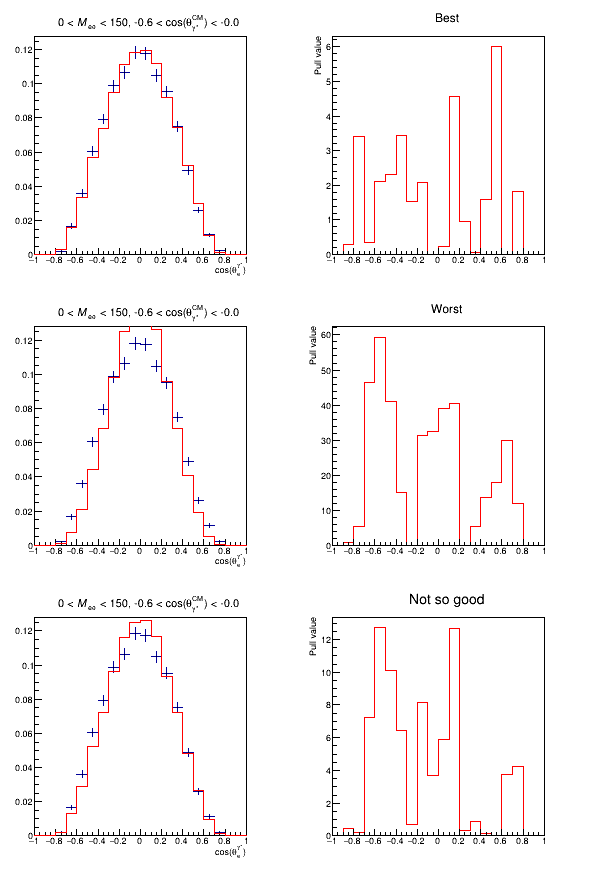

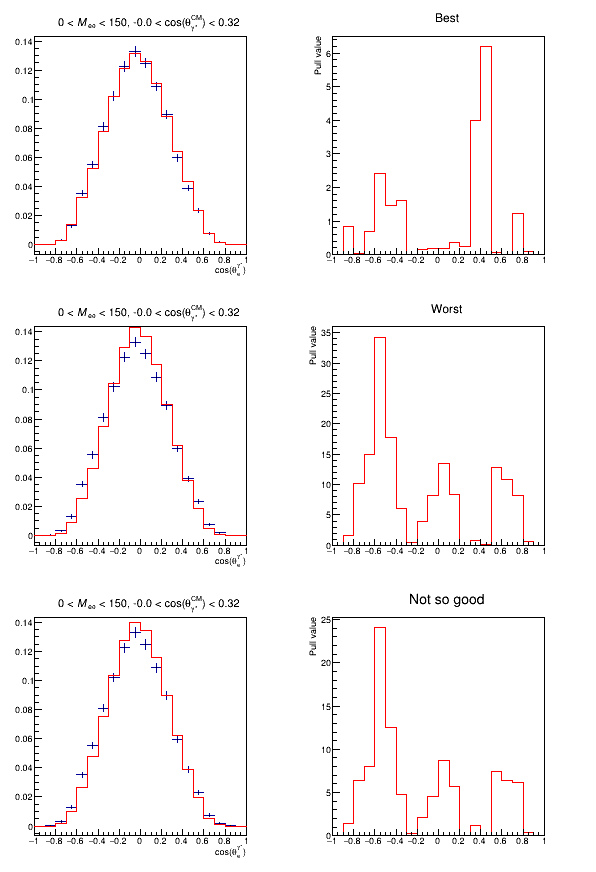

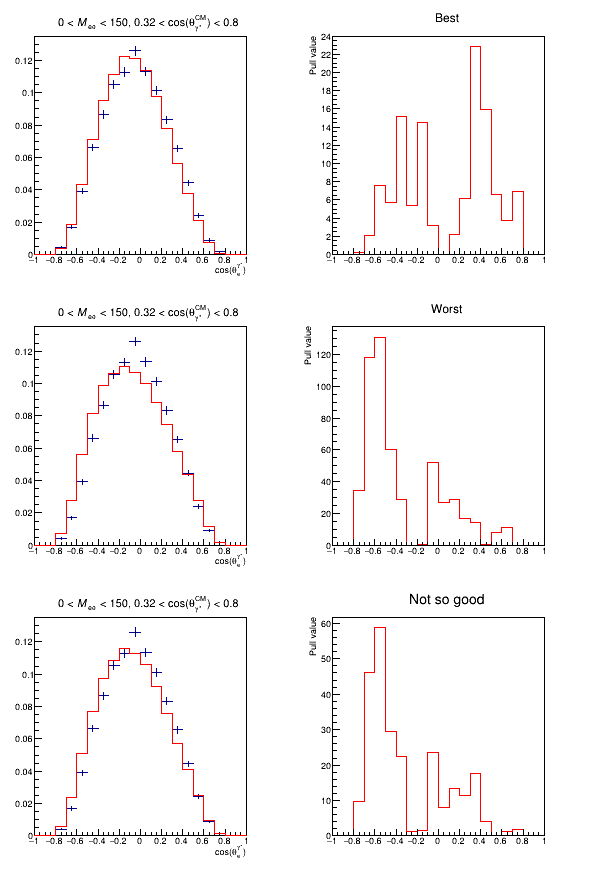

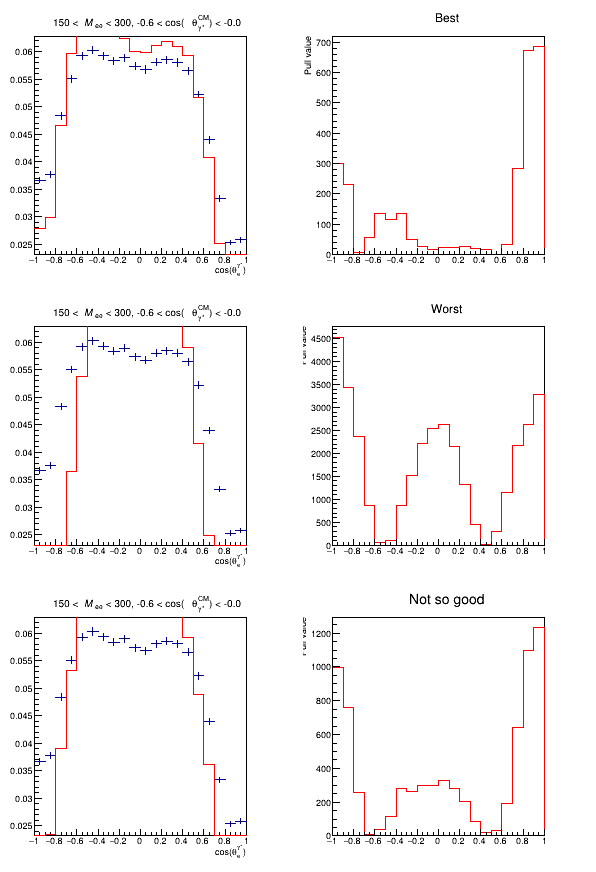

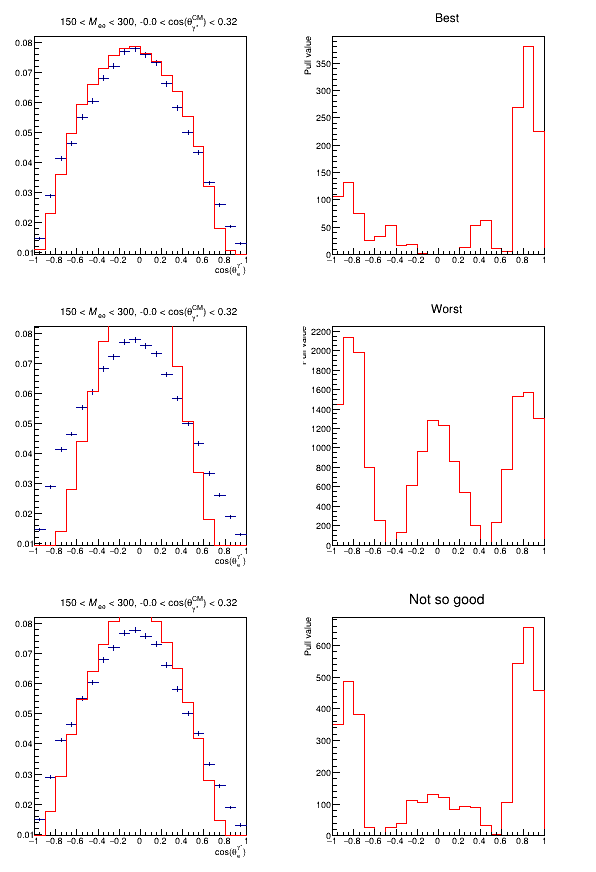

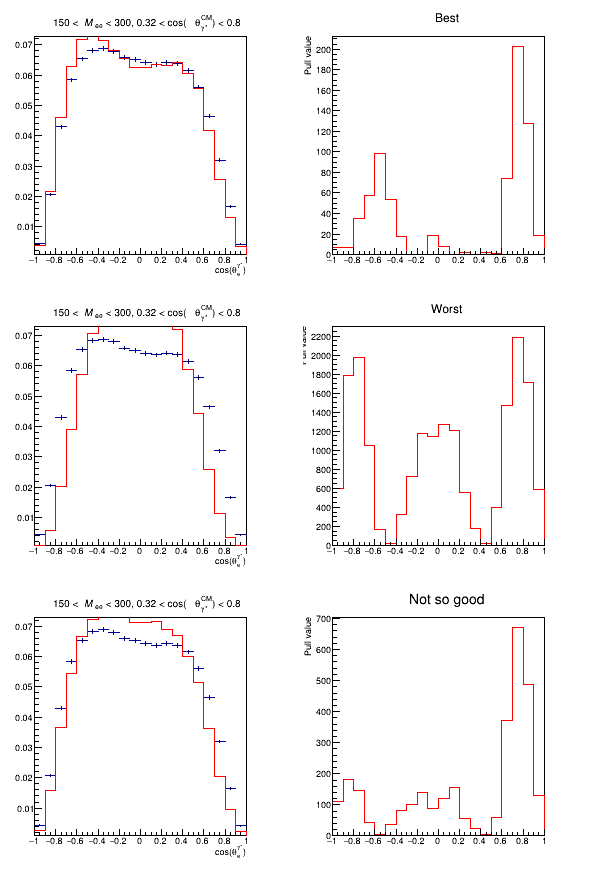

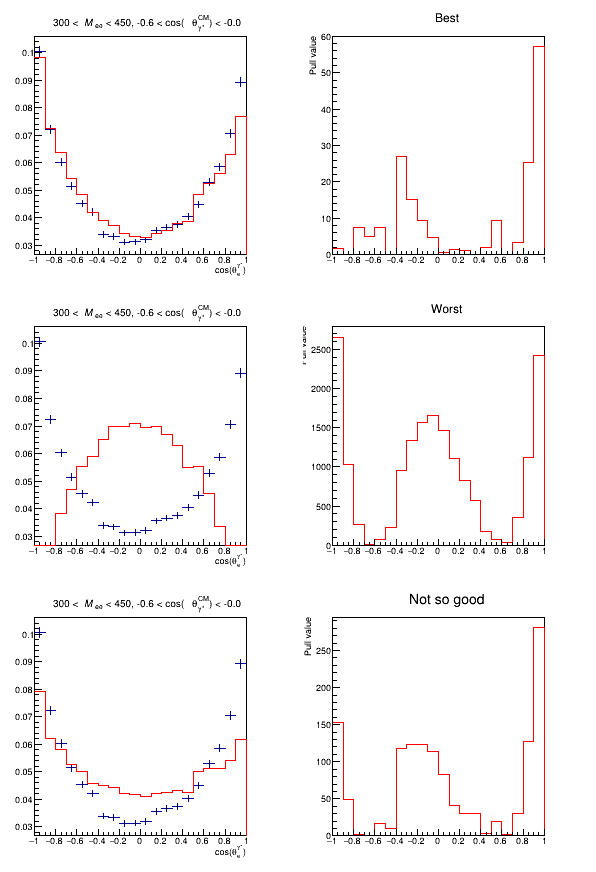

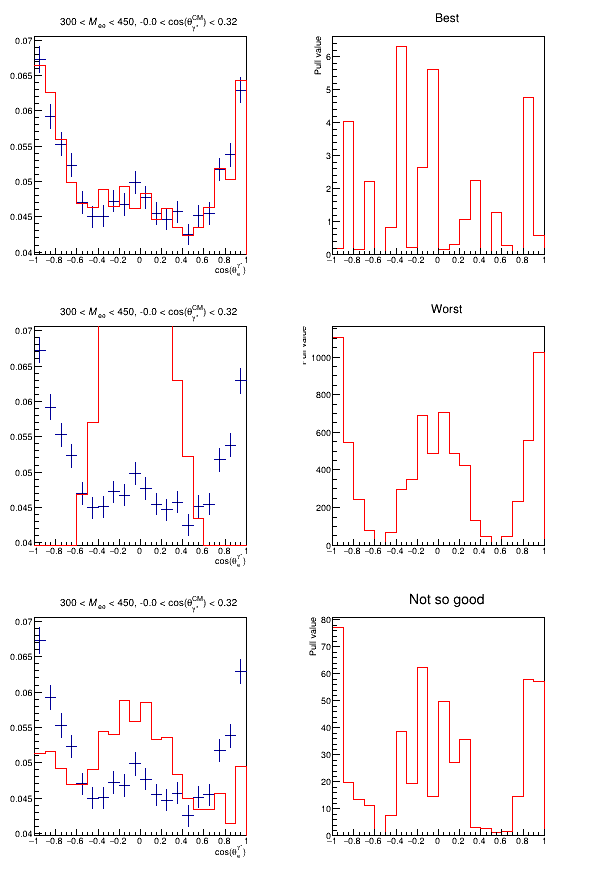

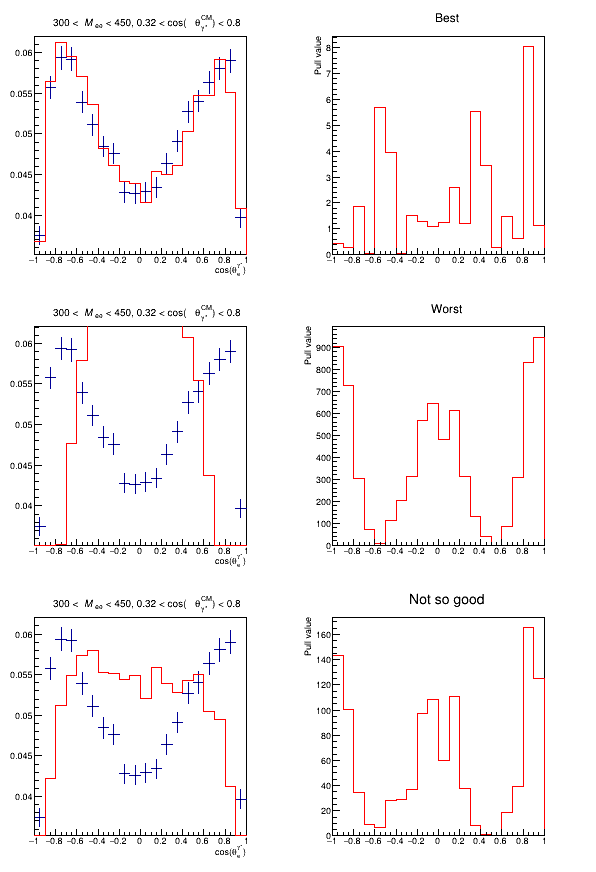

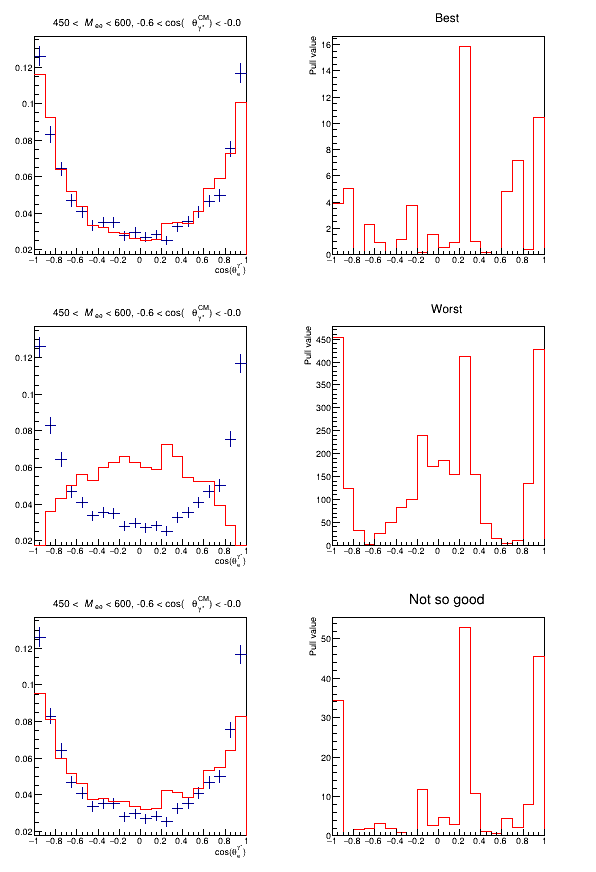

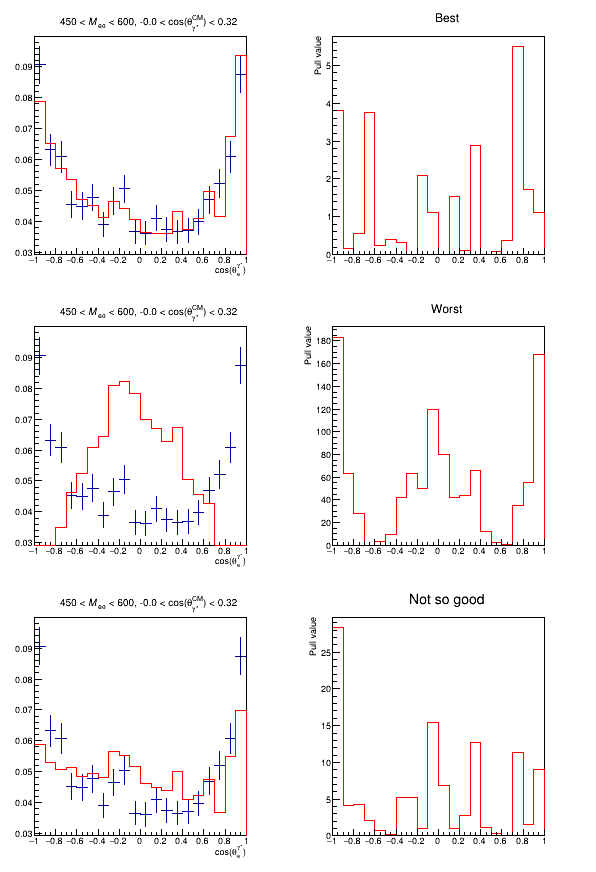

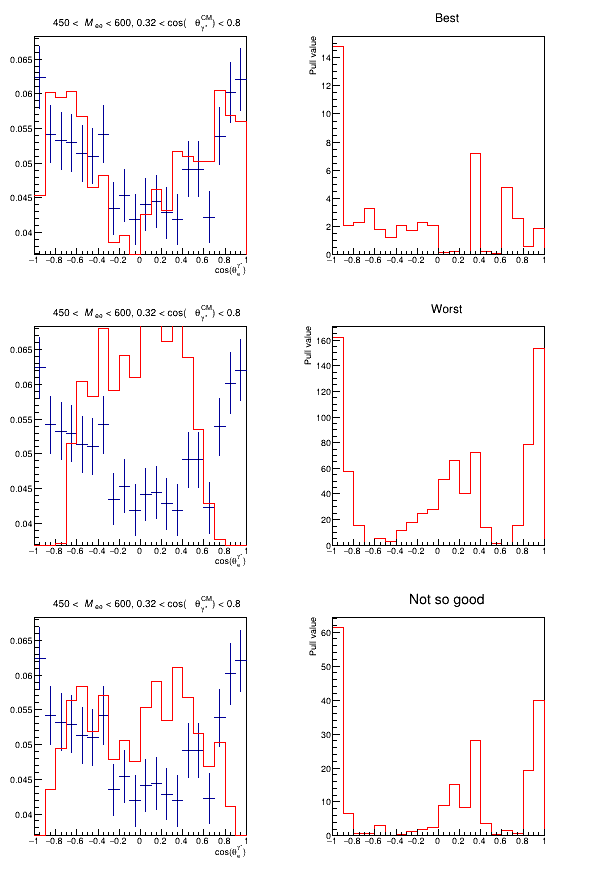

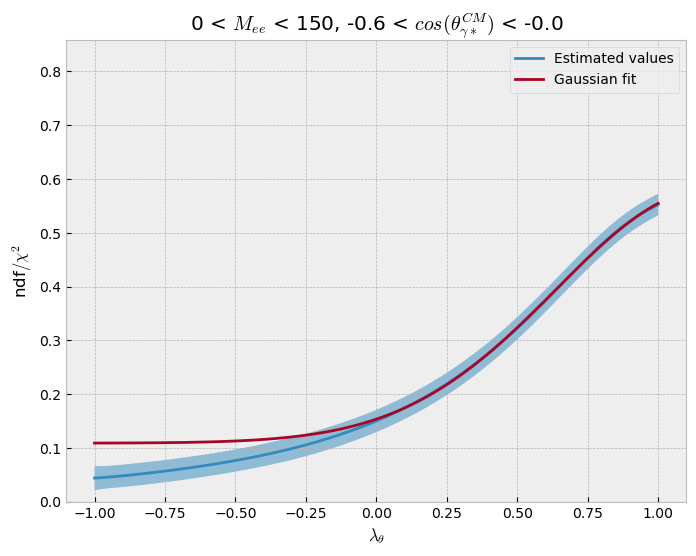

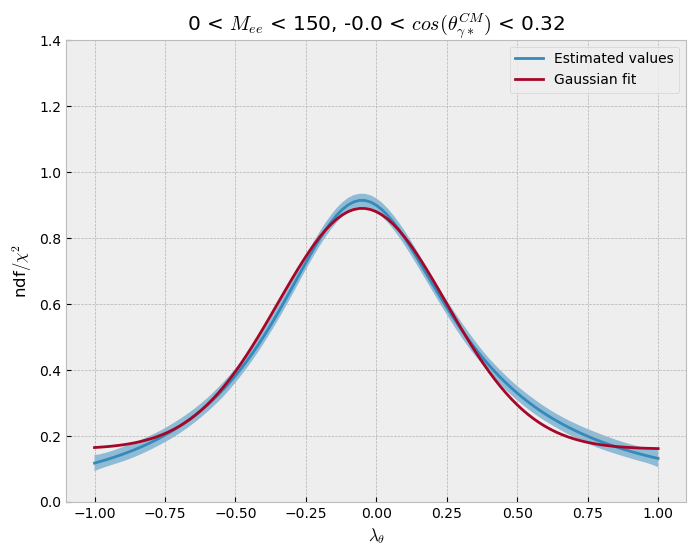

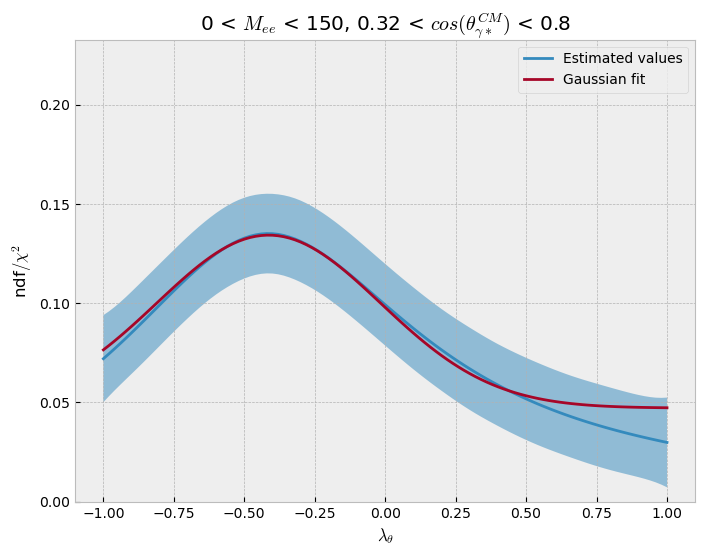

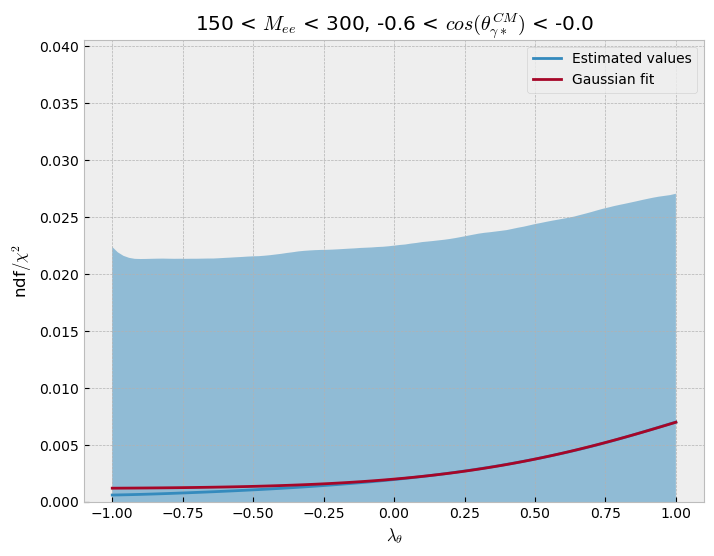

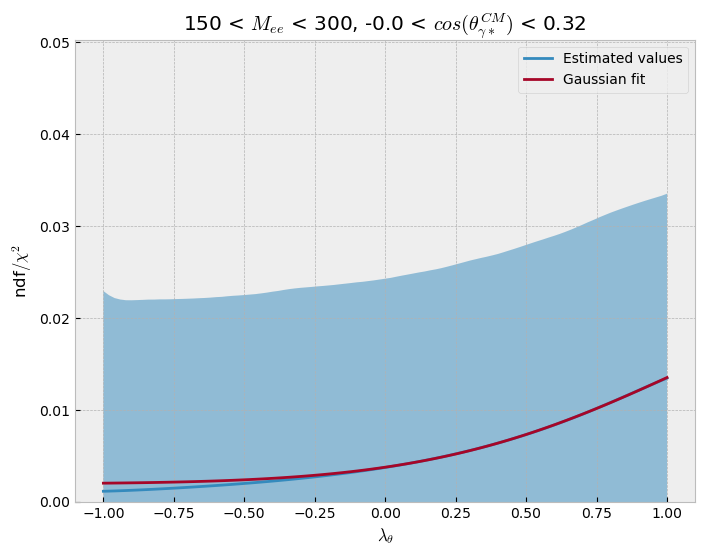

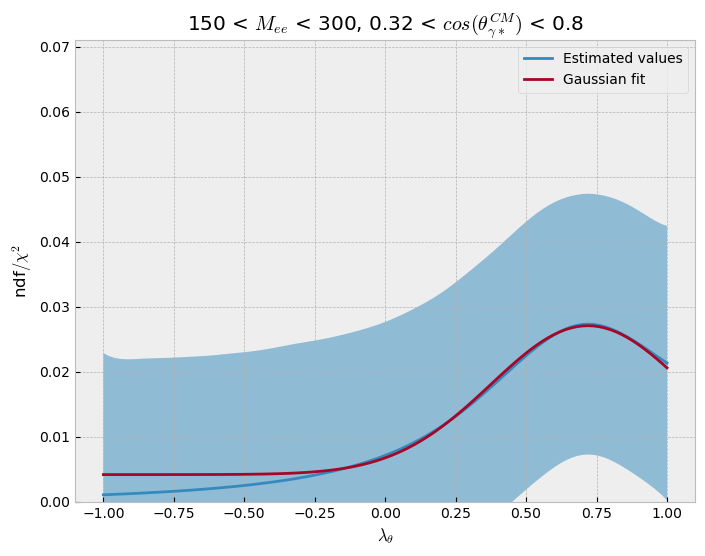

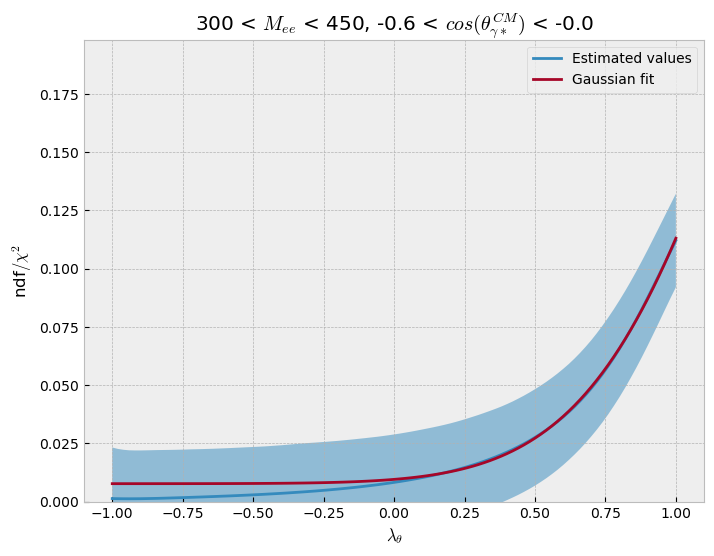

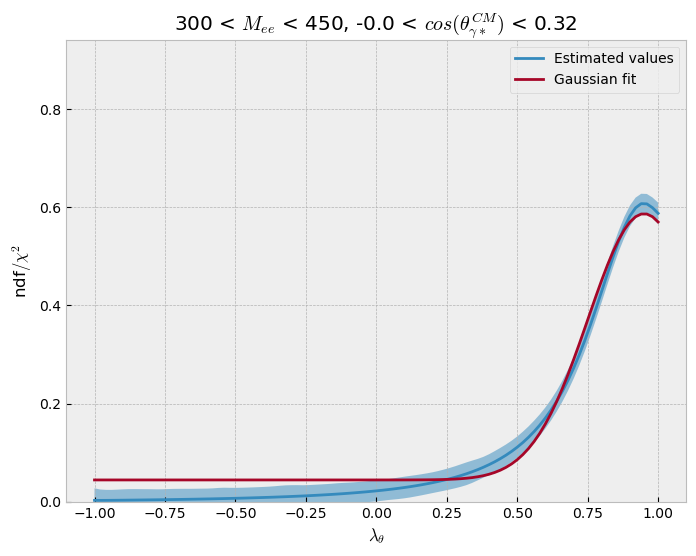

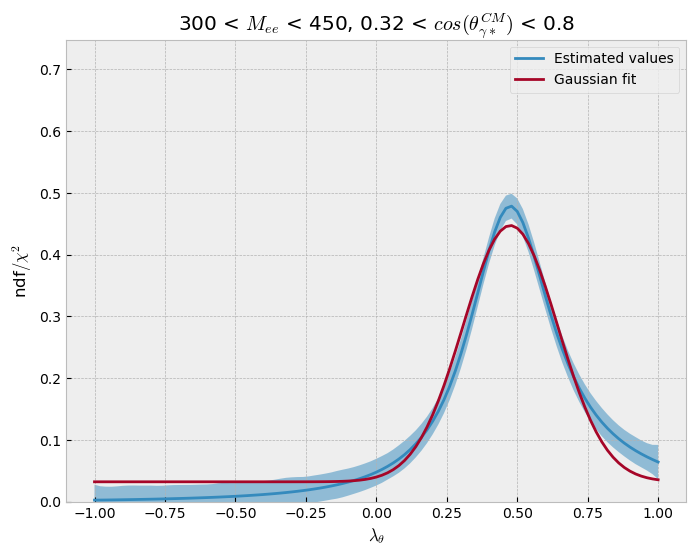

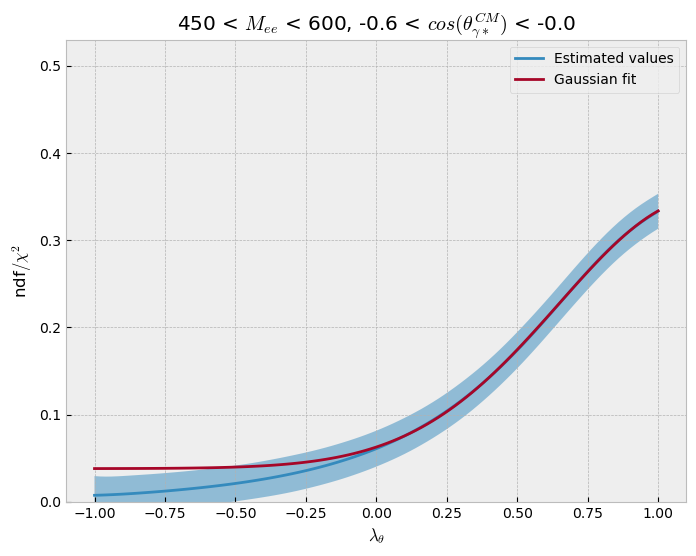

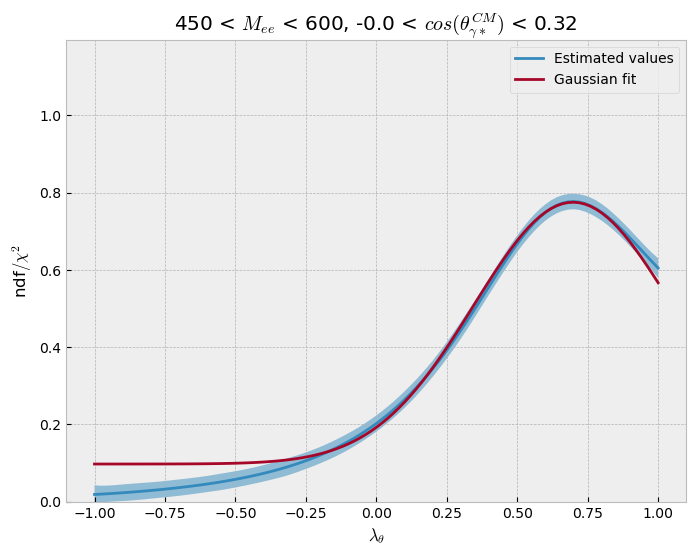

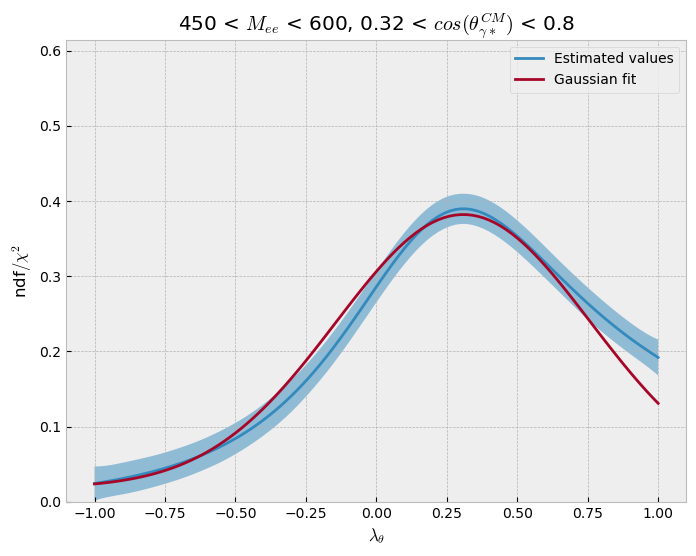

In [127]:

with open(f'{DIR_NAME}/results.txt', 'w') as fout:
    canvases = []
    hdiffs = []
    hmodels = []
    
    for HIST_INDEX in range_used:

        c_sorted = c_sorted_all[HIST_INDEX - range_used.start]
        train_x_sorted = train_x_sorted_all[HIST_INDEX - range_used.start]
        predictive_mean = predictive_mean_all[HIST_INDEX - range_used.start]
        predictive_lower = predictive_lower_all[HIST_INDEX - range_used.start]
        predictive_upper = predictive_upper_all[HIST_INDEX - range_used.start]
        predictive_mean_2 = predictive_mean - predictive_mean.min()

       # ax = plt.axes()
        fig, ax = plt.subplots(nrows=1, ncols=1)
        lambda_theta = train_x_sorted[-1]
        bestHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(bestHistsMC[0][HIST_INDEX])
        
        can1 = TCanvas(f"can_cmp_{HIST_INDEX}","can",600,900)
        can1.Divide(2,3)
        can1.Draw()        
        canvases.append(can1)
        
        hdiff1 = plotComparison(can1, 1, 2, bestHistsMC[0][HIST_INDEX], histsData[0][HIST_INDEX], HIST_INDEX, "Best")
        hdiffs.append(hdiff1)
        
        lambda_theta = train_x_sorted[0]
        worstHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(worstHistsMC[0][HIST_INDEX])
        hdiff2 = plotComparison(can1, 3, 4, worstHistsMC[0][HIST_INDEX], histsData[0][HIST_INDEX], HIST_INDEX, "Worst")
        hdiffs.append(hdiff2)

        shift = 0.75
        if train_x_sorted[-1] > shift - 1:
            diffToBest = torch.tensor([-shift])
        else:
            diffToBest = torch.tensor([+shift])
        lambda_theta = train_x_sorted[-1] + diffToBest
        notSoGoodHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(notSoGoodHistsMC[0][HIST_INDEX])
        hdiff22 = plotComparison(can1, 5, 6, notSoGoodHistsMC[0][HIST_INDEX], histsData[0][HIST_INDEX], HIST_INDEX, "Not so good")
        hdiffs.append(hdiff22)

        can1.SaveAs(f"{DIR_NAME}/comparison_{HIST_INDEX}.gif")

        print(str(HIST_INDEX) + ": Final result:")
        print(str(HIST_INDEX) + ": Final result:", file=fout)
        print(str(HIST_INDEX) + ": lambda_theta = ", c_sorted[-1][1].item())
        print(str(HIST_INDEX) + ": lambda_theta = ", c_sorted[-1][1].item(), file=fout)

        drphiz = covariance_fit_scipy(predictive_mean,predictive_lower,predictive_upper,train_x_sorted[-1],HIST_INDEX,ax)

        try:
            print(str(HIST_INDEX) + ": errors = ", drphiz)
            print(str(HIST_INDEX) + ": errors = ", drphiz, file=fout)
        except:
            print(str(HIST_INDEX) + ": errors could not be determined")
            print(str(HIST_INDEX) + ": errors could not be determined", file=fout)